In [1]:
from Bio import Entrez, SeqIO, pairwise2
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [42]:
gene_names = ["ADH1", "ADH2", "ADH3", 
              "ALD2", "ALD3", "ALD4", "ALD5", "ALD6",
              "CUP1-1", "CUP1-2",
              "ENO1", "ENO2", "ERR1", "ERR2", "ERR3", 
              "FLO1", "FLO5", "FLO9", 
              "HTA1", "HTA2", "HTB1", "HTB2", "HHT1", "HHT2", "HHF1", "HHF2",
              "HSP82", "HSC82",
              "HXT1", "HXT2", "HXT3", "HXT4", "HXT5", "HXT6", "HXT7", "HXT8", "HXT9",
              "HXT10", "HXT11", "HXT12", "HXT13", "HXT15", "HXT16", "HXT17", "GAL2",
              "MAN1", "MAN2",
              "MEP1", "MEP2", "MEP3",
              "PAU1", "PAU2", "PAU3", "PAU4", "PAU5", "PAU6", "PAU8", "PAU10", "PAU11", "PAU12", "PAU13", "PAU14", 
              "PAU15", "PAU16", "PAU17", "PAU18", "PAU19", "PAU20", "PAU21", "PAU22", "PAU23", "PAU24",
              "PDC1", "PDC5", "PDC6",
              "RPL4A", "RPL4B",
              "RPL6A", "RPL6B",
              "RPL7A", "RPL7B",
              "RPL12A", "RPL12B",
              "RPL13A", "RPL13B",
              "RPL15A", "RPL15B",
              "RPL16A", "RPL16B",
              "RPL17A", "RPL17B",
              "RPL18A", "RPL18B",
              "RPL19A", "RPL19B",
              "RPL21A", "RPL21B",
              "RPL22A", "RPL22B",
              "RPL23A", "RPL23B",
              "RPL24A", "RPL24B",
              "RPL26A", "RPL26B",
              "RPL27A", "RPL27B",
              "RPL33A", "RPL33B",
              "RPL34A", "RPL34B",
              "RPL35A", "RPL35B",
              "RPL36A", "RPL36B",
              "RPL37A", "RPL37B",
              "RPS1A", "RPS1B",
              "RPS6A", "RPS6B",
              "RPS8A", "RPS8B",
              "RPS9A", "RPS9B",
              "RPS11A", "RPS11B",
              "RPS14A", "RPS14B",
              "RPS15A", "RPS15B",
              "RPS16A", "RPS16B",
              "RPS17A", "RPS17B",
              "RPS18A", "RPS18B",
              "RPS21A", "RPS21B",
              "RPS24A", "RPS24B",
              "RPS27A", "RPS27B",
              "SNO1", "SNO2", "SNO3", "SNZ1", "SNZ2", "SNZ3",
              "SSA1", "SSA2", "SSA3", "SSA4",
              "TSA1", "TSA2"
             ]

Fetch the refseq identifiers for all the genes

In [43]:
Entrez.email = "youremail"

def get_refseq_id(gene_name, organism="Saccharomyces cerevisiae"):
    """Fetch the RefSeq mRNA accession for a gene from NCBI Gene database."""
    try:
        # Search in the Gene database
        query = f"{gene_name}[Gene Name] AND {organism}[Organism]"
        search = Entrez.esearch(db="gene", term=query, retmode="xml")
        result = Entrez.read(search)
        search.close()

        if not result["IdList"]:
            print(f"[!] No Gene ID found for {gene_name}")
            return None

        gene_id = result["IdList"][0]

        # Fetch gene summary
        handle = Entrez.efetch(db="gene", id=gene_id, retmode="xml")
        records = Entrez.read(handle)
        handle.close()

        # Try to extract RefSeq mRNA accession
        for gene in records:
            try:
                for item in gene['Entrezgene_locus']:
                    for tag in item['Gene-commentary_products']:
                        accession = tag['Gene-commentary_accession']
                        if accession.startswith("NM_") or accession.startswith("NR_"):
                            return accession
            except:
                continue
        print(f"[!] RefSeq accession not found for {gene_name}")
        return None

    except Exception as e:
        print(f"[ERROR] {gene_name}: {e}")
        return None

# Run the script
refseq_ids = {}
for gene in gene_names:
    print(f"Fetching RefSeq ID for {gene}...")
    refseq = get_refseq_id(gene)
    if refseq:
        refseq_ids[gene] = refseq
    time.sleep(1)  # NCBI rate limit

print("\nRefSeq mRNA Accessions:")
for gene, refseq in refseq_ids.items():
    print(f"{gene}: {refseq}")

Fetching RefSeq ID for ADH1...
Fetching RefSeq ID for ADH2...
Fetching RefSeq ID for ADH3...
Fetching RefSeq ID for ALD2...
Fetching RefSeq ID for ALD3...
Fetching RefSeq ID for ALD4...
Fetching RefSeq ID for ALD5...
Fetching RefSeq ID for ALD6...
Fetching RefSeq ID for CUP1-1...
Fetching RefSeq ID for CUP1-2...
Fetching RefSeq ID for ENO1...
Fetching RefSeq ID for ENO2...
Fetching RefSeq ID for ERR1...
Fetching RefSeq ID for ERR2...
Fetching RefSeq ID for ERR3...
Fetching RefSeq ID for FLO1...
Fetching RefSeq ID for FLO5...
Fetching RefSeq ID for FLO9...
Fetching RefSeq ID for HTA1...
Fetching RefSeq ID for HTA2...
Fetching RefSeq ID for HTB1...
Fetching RefSeq ID for HTB2...
Fetching RefSeq ID for HHT1...
Fetching RefSeq ID for HHT2...
Fetching RefSeq ID for HHF1...
Fetching RefSeq ID for HHF2...
Fetching RefSeq ID for HSP82...
Fetching RefSeq ID for HSC82...
Fetching RefSeq ID for HXT1...
Fetching RefSeq ID for HXT2...
Fetching RefSeq ID for HXT3...
Fetching RefSeq ID for HXT4...
Fe

Retrieve the nucleotide fasta sequence for each refseq identifier and compute the sequence similarity matrix of all the gene pairs.

In [44]:

# Step 1: Fetch sequences
def fetch_sequence_from_refseq(accession):
    """Download the nucleotide sequence given a RefSeq accession."""
    try:
        handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
        seq_record = SeqIO.read(handle, "fasta")
        handle.close()
        return seq_record.seq
    except Exception as e:
        print(f"[ERROR] Failed to fetch {accession}: {e}")
        return None

# Download sequences for all genes
sequences = {}
for gene, accession in refseq_ids.items():
    print(f"Fetching sequence for {gene} ({accession})...")
    seq = fetch_sequence_from_refseq(accession)
    if seq:
        sequences[gene] = seq
    time.sleep(1)  # Be nice to NCBI

# Step 2: Compute similarity between all pairs
def compute_similarity(seq1, seq2):
    """Compute global sequence similarity as identity percentage."""
    alignment = pairwise2.align.globalxx(seq1, seq2, one_alignment_only=True)[0]
    matches = alignment[2]
    max_len = max(len(seq1), len(seq2))
    return round(matches / max_len, 4)

# Step 3: Create similarity matrix
genes = list(sequences.keys())
matrix = pd.DataFrame(index=genes, columns=genes)

for g1 in genes:
    for g2 in genes:
        if g1 == g2:
            matrix.loc[g1, g2] = 1.0
        else:
            sim = compute_similarity(sequences[g1], sequences[g2])
            matrix.loc[g1, g2] = sim

# Step 4: Output matrix
print("\nPairwise Nucleotide Similarity Matrix:")
print(matrix)

# Optional: save to CSV
matrix.to_csv("gene_similarity_matrix.csv")

Fetching sequence for ADH1 (NM_001183340)...
Fetching sequence for ADH2 (NM_001182812)...
Fetching sequence for ADH3 (NM_001182582)...
Fetching sequence for ALD2 (NM_001182674)...
Fetching sequence for ALD3 (NM_001182673)...
Fetching sequence for ALD4 (NM_001183794)...
Fetching sequence for ALD5 (NM_001178964)...
Fetching sequence for ALD6 (NM_001183875)...
Fetching sequence for CUP1-1 (NM_001179185)...
Fetching sequence for CUP1-2 (NM_001179183)...
Fetching sequence for ENO1 (NM_001181383)...
Fetching sequence for ENO2 (NM_001179305)...
Fetching sequence for ERR1 (NM_001183813)...
Fetching sequence for ERR2 (NM_001184095)...
Fetching sequence for ERR3 (NM_001182836)...
Fetching sequence for FLO1 (NM_001178230)...
Fetching sequence for FLO5 (NM_001179342)...
Fetching sequence for FLO9 (NM_001178205)...
Fetching sequence for HTA1 (NM_001180533)...
Fetching sequence for HTA2 (NM_001178243)...
Fetching sequence for HTB1 (NM_001180532)...
Fetching sequence for HTB2 (NM_001178242)...
Fetchi

Filter the table to remove all similarity scores below 70% and plot the similarity matrix

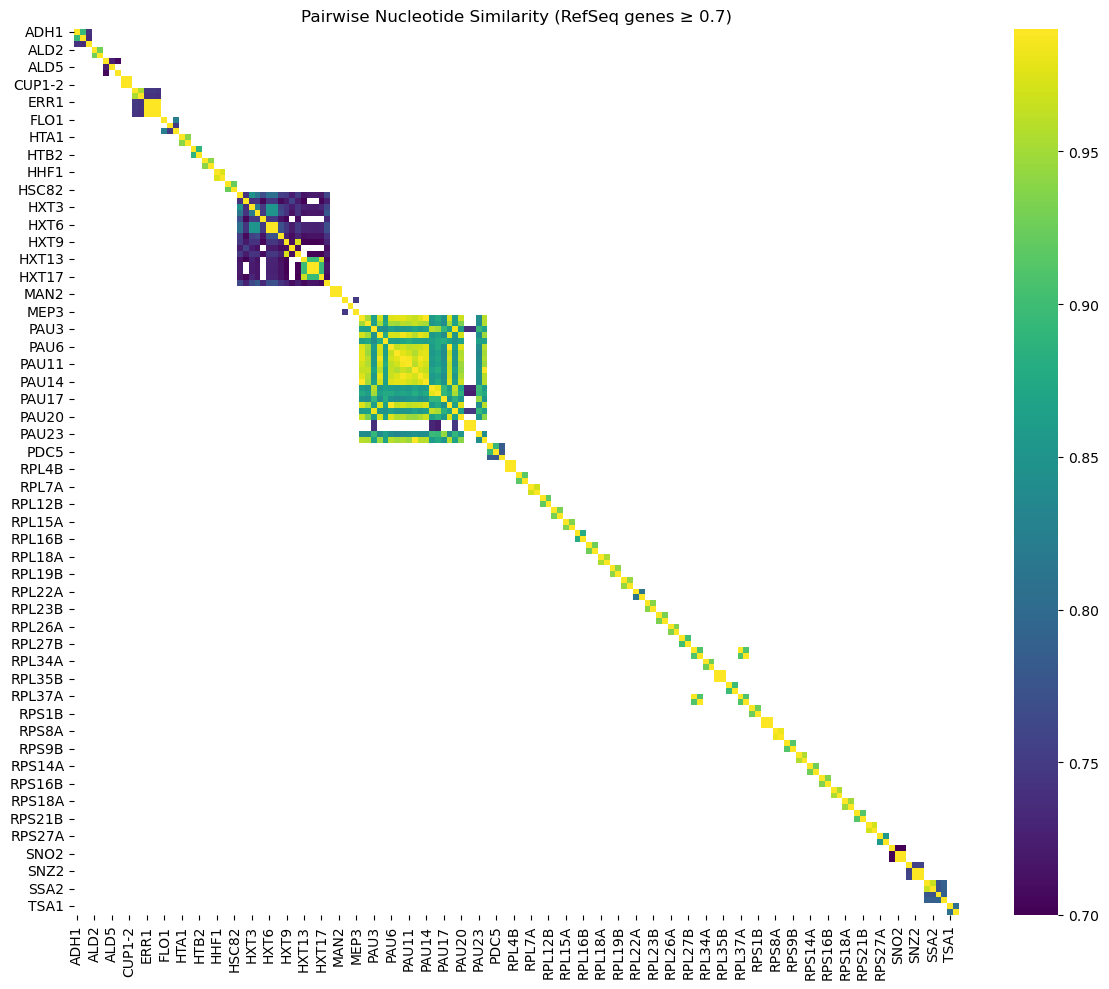

In [45]:
matrix = matrix.applymap(lambda x: x if float(x) >= 0.7 else "")

# Convert non-numeric (empty string) to NaN
matrix_filtered = matrix.replace("", np.nan).astype(float)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(matrix_filtered, annot=False, cmap="viridis", vmin=0.7, vmax=0.99, linewidths=0, linecolor='gray')

plt.title("Pairwise Nucleotide Similarity (RefSeq genes ≥ 0.7)")
plt.tight_layout()
plt.savefig("similarity_heatmap.pdf", dpi=300)
plt.show()